In [1]:
import random
import math

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
import joblib

import scipy

In [4]:
plt.rcParams["figure.figsize"] = (15, 10)

## load random forest model

In [5]:
filename_min = './min_random_forest_model.sav'
filename_max = './max_random_forest_model.sav'

In [6]:
rfr_min = joblib.load(filename_min)
rfr_max = joblib.load(filename_max)

## create test data from test dataset

In [7]:
pth_min = '../processed_data/test_min.csv'
df_min = pd.read_csv(pth_min)

In [8]:
pth_max = '../processed_data/test_max.csv'
df_max = pd.read_csv(pth_max)

In [9]:
df_min.shape

(57, 14)

In [10]:
df_max.shape

(9, 14)

In [19]:
df_combine = pd.concat([df_min, df_max])

In [11]:
X_columns = ['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
              'heart_rate', 'stress_level', 'skin_temp', 'eda', \
              'Clo', 'Act']

In [21]:
X = df_combine[X_columns]
y = df_combine['env_temp']

## predict

### predict comfort zone min value

In [22]:
y_pred_min = rfr_min.predict(X)

In [23]:
y_pred_min

array([77.8729575 , 77.66955125, 75.91897375, 75.66193   , 77.41612   ,
       75.60589875, 77.1462925 , 74.714305  , 76.06178875, 76.927855  ,
       76.4461025 , 76.61222   , 75.25098375, 75.84258625, 76.68548125,
       76.453345  , 75.13615875, 75.170635  , 75.9777175 , 75.24051625,
       74.2163675 , 77.27317125, 75.016495  , 74.6061125 , 77.38071   ,
       75.21640125, 75.24631375, 76.794885  , 73.23543125, 77.28352688,
       75.91466625, 77.599275  , 76.30652   , 75.335175  , 76.9138425 ,
       74.9525475 , 76.65944875, 75.2969125 , 75.36264875, 76.363295  ,
       73.6366675 , 75.48528375, 75.80248875, 75.72660875, 72.63320125,
       76.2198475 , 75.35760875, 75.71972125, 76.40053375, 77.66959625,
       74.72975875, 76.87741125, 76.49084125, 74.76215   , 75.36342625,
       75.344085  , 76.59576125, 78.49592125, 78.72751625, 77.79993125,
       74.92391875, 77.59985625, 75.61948625, 76.7343775 , 75.24171875,
       77.69428375])

### predict comfort zone max value

In [24]:
y_pred_max = rfr_max.predict(X)

In [25]:
y_pred_max

array([80.18065067, 83.43914267, 78.22929   , 77.82742933, 76.90958467,
       81.02271133, 76.96292   , 78.620292  , 79.06775867, 78.62710667,
       79.03040333, 78.35095733, 81.11198   , 78.21078733, 81.054242  ,
       79.06257   , 79.57182733, 78.42522867, 80.93662467, 81.06226533,
       77.850432  , 80.769524  , 77.820342  , 77.88916933, 79.67023733,
       78.186392  , 81.06760133, 79.71338467, 78.31587533, 76.88793667,
       80.935894  , 77.65801733, 79.54723867, 78.13563667, 77.28215667,
       77.32081467, 79.13381867, 77.764504  , 77.92285267, 79.57027667,
       78.42566867, 77.92424733, 80.39415267, 77.92409133, 78.046656  ,
       78.50175067, 81.15674067, 79.16748933, 79.43164533, 79.81379267,
       81.142094  , 77.52501333, 79.21645867, 79.60715133, 77.95206467,
       77.62981733, 78.81184867, 79.485776  , 80.85504667, 78.79232933,
       80.533886  , 80.40944667, 76.65071133, 78.92736267, 80.15540333,
       78.871312  ])

### delete the unacceptable values

In [27]:
t_min = []
t_max = []
for i in range(len(y_pred_min)):
    if y_pred_min[i] <= y_pred_max[i]:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_max[i])
    else:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_min[i])

In [28]:
len(t_min)

66

### plot zone

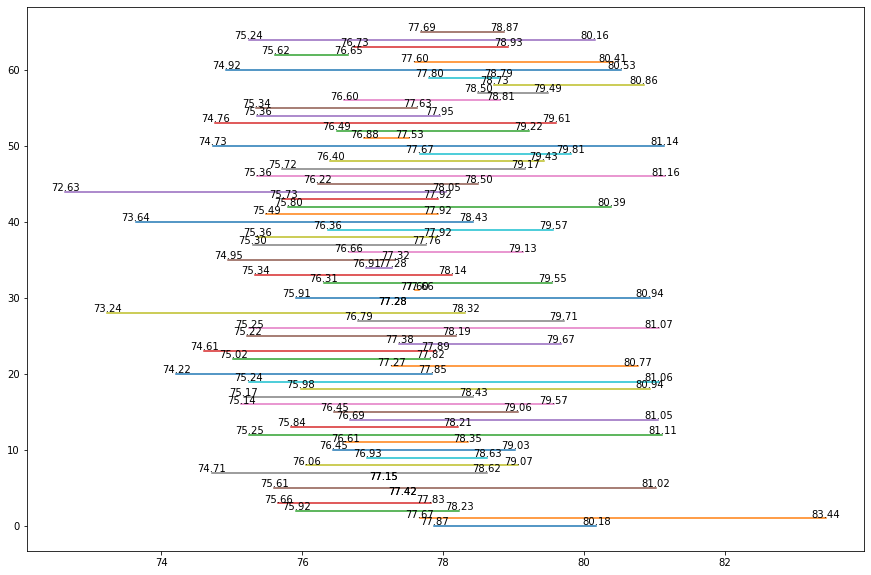

In [29]:
# draw comfort zone
for i in range(len(t_min)):
    plt.plot([t_min[i], t_max[i]],[i, i])
    
# tag comfort zone min $ max
for i in range(len(t_min)):
    plt.text(t_min[i]-0.2, i+0.1, "%.2f" % t_min[i])
    plt.text(t_max[i]-0.2, i+0.1, "%.2f" % t_max[i])

plt.show()

## predict group tempreture model

In [44]:
import math

class OptimalGroupTempreture():
    def __init__(self, minTs, maxTs, sensitivity=1.0, defaultMinMaxRange=1.0):
        """
        sensitivity > 0, less means more sensitive
        defaultMinMaxRange > 0 or == None
        """
        if len(minTs) != len(maxTs):
            print('Length of min tempreture records and max tempretur records are not equal!')
            return None
        self.minTs = minTs
        self.maxTs = maxTs
        self.sensitivity = sensitivity
        self.defaultMinMaxRange = defaultMinMaxRange
    
    def getTempreture(self, model='auto', sensitivePeoplePercentageLimit=0.1, sensitiveRange=2, ppd=0.1):
        """
        model = 'auto', 'sensitive first', 'otd model'
        sensitivePeoplePercentage is > 0 and < 1
        sensitiveRange is > 0, unit is Fahrenheit Degree
        ppd: only for OTD model
        """
        minTs = self.minTs
        maxTs = self.maxTs

        if self.defaultMinMaxRange is not None:
            avgTs = [(maxTs[i] + minTs[i]) / 2 for i in range(len(minTs))]
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                t = tRanges[i] if tRanges[i] > 0 else self.defaultMinMaxRange
                checkedtRanges.append(t)
        else:
            avgTs = []
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                if tRanges[i] > 0:
                    t = tRanges[i]
                    checkedtRanges.append(t)
                    avgTs.append((maxTs[i] + minTs[i]) / 2)

        # model selection
        if model == 'sensitive first':
            print('sensitive first model')
            targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        elif model == 'otd model':
            print('otd model')
            targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
        elif model == 'auto':
            lengthOfSensitivePeople = len([tRange for tRange in checkedtRanges if tRange <= sensitiveRange])
            if lengthOfSensitivePeople / len(checkedtRanges) >= sensitivePeoplePercentageLimit:
                print('sensitive first model')
                print('sensitive people percentage:', lengthOfSensitivePeople / len(checkedtRanges))
                targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
            else:
                print('otd model')
                targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
                if targetTempreture is None:
                    print('otd model does not find a acceptable value, use sensitive first model')
                    targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        else:
            print('Wrong model')
            return None

        return targetTempreture

    def sensitiveFirst(self, checkedtRanges, averageTs):
        weights = [self.computeWeight(tRange) for tRange in checkedtRanges]
        weightedTs = [averageTs[i] * weights[i] for i in range(len(averageTs))]
        targetTempreture = sum(weightedTs) / sum(weights)
        return targetTempreture

    def computeWeight(self, tRange):
        return (1 / tRange) ** self.sensitivity

    def otdModel(self, checkedtRanges, averageTs, ppd):
        numberOfPeople = len(checkedtRanges)
        permitNumberOfUncomfortablePeople = math.floor(numberOfPeople * ppd)
        otdMax = (numberOfPeople - permitNumberOfUncomfortablePeople) * 1 + \
            permitNumberOfUncomfortablePeople * (numberOfPeople + 1)

        rangeTs = [self.otdDecideComfortness(checkedtRanges[i], averageTs[i]) for i in range(len(checkedtRanges))]

        # find minT and maxT
        minT = min([averageTs[i] - checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])
        maxT = max([averageTs[i] + checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])

        acceptableTs = []
        for t10 in range(int(minT * 10), int(maxT * 10) + 1):
            t = t10 / 10
            otd = 0
            for x in rangeTs:
                if t >= x[0][0] and t <= x[0][1]:
                    otd += 0
                elif t >= x[1][0] and t <= x[1][1]:
                    otd += 1
                elif t >= x[2][0] and t <= x[2][1]:
                    otd += numberOfPeople + 1
                else:
                    otd = (numberOfPeople + 1) * 2
            if otd <= otdMax:
                acceptableTs.append([t, otd])
        if acceptableTs == []:
            return None
        acceptableTs.sort(key=lambda x: x[1])
        maxValues = [acceptableTs[0][0]]
        for i in range(1, len(acceptableTs)):
            if acceptableTs[i][1] == acceptableTs[0][1]:
                maxValues.append(acceptableTs[i][0])
#         print(acceptableTs)
        return sum(maxValues) / len(maxValues)

                
    def otdDecideComfortness(self, checkedtRange, averageT, \
                            littleUncomfortable=[1 , 1.4], \
                            uncomfortable=[1.4, 1.7]):
        radius = checkedtRange / 2
        rangeComfortable = [averageT - radius * littleUncomfortable[0], averageT + radius * littleUncomfortable[0]]
        rangeLittleUncomfortable = [averageT - radius * littleUncomfortable[1], averageT + radius * littleUncomfortable[1]]
        rangeUncomfortable = [averageT - radius * uncomfortable[1], averageT + radius * uncomfortable[1]]
        return [rangeComfortable, rangeLittleUncomfortable, rangeUncomfortable]

In [45]:
ogt = OptimalGroupTempreture(y_pred_min, y_pred_max, defaultMinMaxRange=None)

In [46]:
# use sensitive first model to predict the group comfortable tempreture
ogt.getTempreture(sensitiveRange=4)

sensitive first model
sensitive people percentage: 0.7142857142857143


77.56718390599879

In [47]:
# use otd model to predict the group comfortable tempreture
ogt.getTempreture(model='otd model', ppd=0.1)

otd model


77.98019801980197